# Visualizing Audio File

In this notebook, I am just experiementing with visualizing the notes in a wav file.

## Extracting Notes 

First we recreate the method in here: https://medium.com/@gallaghersam95/extract-piano-notes-from-wav-files-in-python-3954a1876e8e

In [11]:
#!pip install librosa pypianoroll
#!pip install pretty_midi

#!pip install -U kaleido

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.io.wavfile as wav
import json

In [14]:
NOTES_MAP = json.load(open("notes-frequencies.json", "r"))

In [16]:
WAVE_LOCATION = "audio_output/audio_0.wav"
DURATION = 3  # Seconds
wav_file = open(WAVE_LOCATION, "rb")
SAMPLE_RATE, data = wav.read(wav_file)

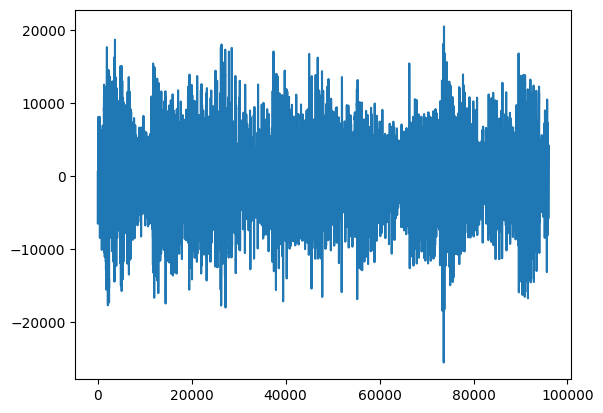

In [17]:
# Plot the time domain
t = 1 * np.arange(SAMPLE_RATE*DURATION)
plt.plot(t, data[:SAMPLE_RATE*DURATION])

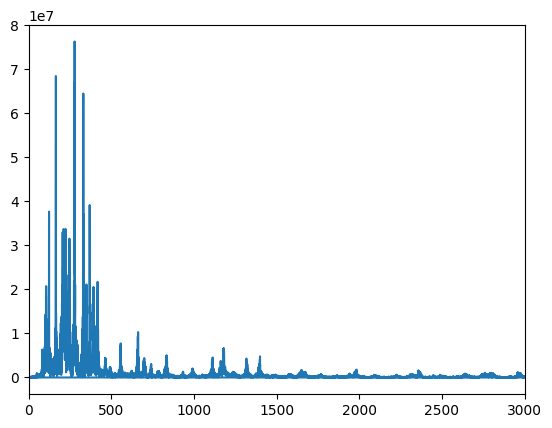

In [18]:
yf = fft(data[:SAMPLE_RATE*DURATION])
xf = fftfreq(SAMPLE_RATE*DURATION, 1 / SAMPLE_RATE)
plt.plot(xf, np.abs(yf))
plt.xlim([0, 3e3])
plt.show()

In [19]:
# Map frequencies to magnitude
y = np.abs(yf)

d = {}
for i in range(0, len(y)):
  if xf[i] > 0:
    d[f"{xf[i]}"] = y[i]

# Sort the dict so highest frequencies are at the top
d = sorted(d, key=d.get, reverse=True)

# Get the top 10 notes
bucket = []
for i in d:
  if len(bucket) == 10:
    break
  i = round(float(i))
  if i not in bucket:
    bucket.append(i)

# Map to notes
notes = []
for i in bucket:
  for note in NOTES_MAP:
    note_freq = NOTES_MAP[note]

    l_r = i - 4
    h_r = i + 4
    if l_r < note_freq and h_r > note_freq:
      notes.append(note)
      break

print(list(set(notes)))

['F#4', 'B2', 'E3', 'E4', 'C#4']


## Visualizing Notes

Now let's try another method to get a movie out of the file. The code comes from: https://github.com/jeffheaton/present/blob/master/youtube/video/fft-frequency.ipynb

In [20]:
# Configuration
FPS = 30
FFT_WINDOW_SECONDS = 0.25 # how many seconds of audio make up an FFT window

# Note range to display
FREQ_MIN = 10
FREQ_MAX = 1000

# Notes to display
TOP_NOTES = 3

# Names of the notes
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# Output size. Generally use SCALE for higher res, unless you need a non-standard aspect ratio.
RESOLUTION = (1920, 1080)
SCALE = 2 # 0.5=QHD(960x540), 1=HD(1920x1080), 2=4K(3840x2160)

In [33]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile # get the api
import os

# Get a WAV file from GDrive, such as:
# AUDIO_FILE = os.path.join(PATH,'short_popcorn.wav')
PATH = '/content/drive/MyDrive/projects/audio'
# Or download my sample audio
#!wget https://github.com/jeffheaton/present/raw/master/youtube/video/sample_audio/piano_c_major_scale.wav
AUDIO_FILE = "/content/piano_c_major_scale.wav"

fs, data = wavfile.read(WAVE_LOCATION) # load the data
audio = data # this is a two channel soundtrack, get the first track
FRAME_STEP = (fs / FPS) # audio samples per video frame
FFT_WINDOW_SIZE = int(fs * FFT_WINDOW_SECONDS)
AUDIO_LENGTH = len(audio)/fs

In [49]:
import plotly.graph_objects as go

def plot_fft(p, xf, fs, notes, dimensions=(960,540)):
  layout = go.Layout(
      title="frequency spectrum",
      autosize=False,
      width=dimensions[0],
      height=dimensions[1],
      xaxis_title="Frequency (note)",
      yaxis_title="Magnitude",
      font={'size' : 24},
      paper_bgcolor='rgb(35, 35, 35)',
      plot_bgcolor='rgb(240, 240, 240)'
  )

  fig = go.Figure(layout=layout,
                  layout_xaxis_range=[FREQ_MIN,FREQ_MAX],
                  layout_yaxis_range=[0,1]
                  )
  
  fig.add_trace(go.Scatter(
      x = xf,
      y = p,
      line=dict(color='rgb(173, 216, 230)'),
      fill='toself',
      fillcolor='rgba(240, 240, 240, 0.3)'
  ))
  
  for note in notes:
    fig.add_annotation(x=note[0]+10, y=note[2],
            text=note[1],
            font = {'size' : 48},
            showarrow=False)
  return fig

def extract_sample(audio, frame_number):
  end = frame_number * FRAME_OFFSET
  begin = int(end - FFT_WINDOW_SIZE)

  if end == 0:
    # We have no audio yet, return all zeros (very beginning)
    return np.zeros((np.abs(begin)),dtype=float)
  elif begin<0:
    # We have some audio, padd with zeros
    return np.concatenate([np.zeros((np.abs(begin)),dtype=float),audio[0:end]])
  else:
    # Usually this happens, return the next sample
    return audio[begin:end]

def find_top_notes(fft,num):
  if np.max(fft.real)<0.001:
    return []

  lst = [x for x in enumerate(fft.real)]
  lst = sorted(lst, key=lambda x: x[1],reverse=True)

  idx = 0
  found = []
  found_note = set()
  while( (idx<len(lst)) and (len(found)<num) ):
    f = xf[lst[idx][0]]
    y = lst[idx][1]
    n = freq_to_number(f)
    n0 = int(round(n))
    name = note_name(n0)

    if name not in found_note:
      found_note.add(name)
      s = [f,note_name(n0),y]
      found.append(s)
    idx += 1
    
  return found

In [45]:
import numpy as np
import tqdm

!rm /content/*.png

# See https://newt.phys.unsw.edu.au/jw/notes.html
def freq_to_number(f): return 69 + 12*np.log2(f/440.0)
def number_to_freq(n): return 440 * 2.0**((n-69)/12.0)
def note_name(n): return NOTE_NAMES[n % 12] + str(int(n/12 - 1))

# Hanning window function
window = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, FFT_WINDOW_SIZE, False)))

xf = np.fft.rfftfreq(FFT_WINDOW_SIZE, 1/fs)
FRAME_COUNT = int(AUDIO_LENGTH*FPS)
FRAME_OFFSET = int(len(audio)/FRAME_COUNT)

# Pass 1, find out the maximum amplitude so we can scale.
mx = 0
for frame_number in range(FRAME_COUNT):
  sample = extract_sample(audio, frame_number)

  fft = np.fft.rfft(sample * window)
  fft = np.abs(fft).real 
  mx = max(np.max(fft),mx)

print(f"Max amplitude: {mx}")

# Pass 2, produce the animation
for frame_number in tqdm.tqdm(range(FRAME_COUNT)):
  sample = extract_sample(audio, frame_number)

  fft = np.fft.rfft(sample * window)
  fft = np.abs(fft) / mx 
     
  s = find_top_notes(fft,TOP_NOTES)

  fig = plot_fft(fft.real,xf,fs,s,RESOLUTION)
  fig.write_image(f"audio_output/frames/frame{frame_number}.png",scale=2)

'rm' is not recognized as an internal or external command,
operable program or batch file.


Max amplitude: 24653216.3707056


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:50<00:00,  4.72it/s]


In [47]:
!ffmpeg -y -r {FPS} -f image2 -s 1920x1080 -i audio_output/frames/frame%d.png -i {'audio_output/audio_0.wav'} -c:v libx264 -pix_fmt yuv420p movie.mp4

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.1 (GCC) 20200726
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va 

In the streamlit app we will want to run everything above, in another .py file, and then display it as below in the streamlit app.

In [48]:
from IPython.display import Video

# Replace 'movie.mp4' with your actual video file name
video_path = 'movie.mp4'
width, height = 800, 600
Video(video_path, width=width, height=height)